In [1727]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [1728]:
torch.__version__

'2.3.0+cpu'

In [1729]:
# Read CSV file into a DataFrame
dataset = pd.read_csv('UCI_Heart_Disease_Dataset_Combined.csv')

# Extract features and labels from DataFrame
X = dataset.iloc[:, :-1].values  # Assuming the features are in the first columns
y = dataset.iloc[:, -1].values   # Assuming the labels are in the last column

In [1730]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [1731]:
temp_df = pd.DataFrame(X)
temp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.0,0.0,0.0,40.0,1.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0
1,0.0,0.0,1.0,0.0,49.0,0.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0
2,0.0,1.0,0.0,0.0,37.0,1.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0
3,0.0,0.0,0.0,1.0,48.0,0.0,138.0,214.0,0.0,0.0,108.0,1.0,1.5
4,0.0,0.0,1.0,0.0,54.0,1.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,0.0,1.0,0.0,0.0,59.0,1.0,140.0,221.0,0.0,1.0,164.0,1.0,0.0
2939,1.0,0.0,0.0,0.0,60.0,1.0,125.0,258.0,0.0,0.0,141.0,1.0,2.8
2940,1.0,0.0,0.0,0.0,47.0,1.0,110.0,275.0,0.0,0.0,118.0,1.0,1.0
2941,1.0,0.0,0.0,0.0,50.0,0.0,110.0,254.0,0.0,0.0,159.0,0.0,0.0


In [1732]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [1733]:
X_train

array([[0.00e+00, 0.00e+00, 1.00e+00, ..., 1.43e+02, 1.00e+00, 1.20e+00],
       [1.00e+00, 0.00e+00, 0.00e+00, ..., 1.47e+02, 0.00e+00, 1.00e-01],
       [0.00e+00, 0.00e+00, 1.00e+00, ..., 8.00e+01, 1.00e+00, 0.00e+00],
       ...,
       [0.00e+00, 1.00e+00, 0.00e+00, ..., 1.60e+02, 0.00e+00, 2.40e+00],
       [0.00e+00, 1.00e+00, 0.00e+00, ..., 1.33e+02, 0.00e+00, 1.60e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.44e+02, 1.00e+00, 1.40e+00]])

In [1734]:
# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1735]:
# Convert Numpy arrays back to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)  # Assuming labels are integers
y_test = torch.tensor(y_test, dtype=torch.float32)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([2354, 13])
X_test shape: torch.Size([589, 13])
y_train shape: torch.Size([2354])
y_test shape: torch.Size([589])


In [1736]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [1737]:
# constants
INPUT_SHAPE = 13
HIDDEN_UNITS = 32
NUM_EPOCHS = 800
WEIGHT_DECAY = 1e-3
STEP_SIZE = 150
GAMMA = 0.1

In [1738]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V0(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_0 = Classification_V0(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_0

Classification_V0(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1739]:
# loss_fn for all models
loss_fn = nn.BCEWithLogitsLoss()

In [1740]:
# functionize optimizer and scheduler creation
def get_optimizer_and_scheduler(model):
    optimizer = torch.optim.Adam(params=model.parameters(),
                                lr = 0.01, 
                                weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=GAMMA)
    return optimizer, scheduler

In [1741]:
optimizer, scheduler = get_optimizer_and_scheduler(model_0)

In [1742]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

Training and testing loop functions

In [1743]:
def train_step(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module, 
               X_train: torch.Tensor,
               y_train: torch.Tensor,
               device=device):
  
  X_train = X_train.to(device)
  y_train = y_train.to(device)
    ### Training
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()

  # turn logits -> pred props -> pred labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss

  # nn.BCELoss expects prediction probabilities as input
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)

  # nn.BCEWithLogistLoss expects raw logits as input (we will use this)
  loss = loss_fn(y_logits, y_train)

  # Calculate the accuracy
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  return loss.item(), acc
    

In [1744]:
def test_step(model: torch.nn.Module, 
                loss_fn: torch.nn.Module,
                X_test: torch.Tensor,
                y_test: torch.Tensor,
                device=device):
    
    X_test = X_test.to(device)
    y_test= y_test.to(device)
    
    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
    
    return test_loss.item(), test_acc

In [1745]:
def train_model(model:torch.nn.Module, 
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                loss_fn: torch.nn.Module, 
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_test: torch.Tensor,
                y_test: torch.Tensor,
                epochs:int,
                seed: int = None,
                device=device):
  
  if seed:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Build training and evaluation loop
  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model, 
                                       optimizer=optimizer, 
                                       loss_fn=loss_fn, 
                                       X_train=X_train, 
                                       y_train=y_train, 
                                       device=device
                                       )

    test_loss, test_acc = test_step(model=model, 
                                      loss_fn=loss_fn, 
                                      X_test=X_test, 
                                      y_test=y_test, 
                                      device=device
                                      )
    
    scheduler.step()
    
    ### Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {train_loss: .5f} | Acc: {train_acc: .2f}% | Test Loss: {test_loss: .5f} | Test Acc: {test_acc: .2f}%")
      # 5. Update results dictionary
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  print(scheduler.get_last_lr())
  return results

In [1746]:
model_0_results = train_model(model=model_0, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.66427 | Acc:  60.66% | Test Loss:  0.63301 | Test Acc:  67.91%
Epoch: 10 | Loss:  0.54803 | Acc:  74.89% | Test Loss:  0.55644 | Test Acc:  73.17%
Epoch: 20 | Loss:  0.54283 | Acc:  74.43% | Test Loss:  0.53902 | Test Acc:  74.19%
Epoch: 30 | Loss:  0.54368 | Acc:  74.94% | Test Loss:  0.54567 | Test Acc:  72.50%
Epoch: 40 | Loss:  0.54233 | Acc:  74.72% | Test Loss:  0.54170 | Test Acc:  74.02%
Epoch: 50 | Loss:  0.54200 | Acc:  74.94% | Test Loss:  0.54181 | Test Acc:  73.17%
Epoch: 60 | Loss:  0.54192 | Acc:  75.02% | Test Loss:  0.54200 | Test Acc:  73.17%
Epoch: 70 | Loss:  0.54190 | Acc:  74.77% | Test Loss:  0.54180 | Test Acc:  73.51%
Epoch: 80 | Loss:  0.54190 | Acc:  75.23% | Test Loss:  0.54179 | Test Acc:  73.34%
Epoch: 90 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54190 | Test Acc:  73.51%
Epoch: 100 | Loss:  0.54189 | Acc:  75.19% | Test Loss:  0.54179 | Test Acc:  73.34%
Epoch: 110 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54181 | Test Acc:

Epoch: 290 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 300 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 310 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 320 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 330 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 340 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 350 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 360 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 370 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 380 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 390 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 | Test Acc:  73.34%
Epoch: 400 | Loss:  0.54189 | Acc:  75.02% | Test Loss:  0.54182 

In [1747]:
model_0_results

{'train_loss': [0.6642698049545288,
  0.6329371929168701,
  0.6066201329231262,
  0.5851730108261108,
  0.5683866143226624,
  0.5560141205787659,
  0.5479409694671631,
  0.5439445972442627,
  0.5434044599533081,
  0.5452178716659546,
  0.5480298399925232,
  0.5506729483604431,
  0.5524385571479797,
  0.5530474781990051,
  0.5525192618370056,
  0.5510789752006531,
  0.5490906238555908,
  0.5469683408737183,
  0.5450776219367981,
  0.5436641573905945,
  0.5428296327590942,
  0.5425487160682678,
  0.5427064895629883,
  0.5431378483772278,
  0.5436645150184631,
  0.5441290140151978,
  0.5444225072860718,
  0.5444973111152649,
  0.5443633198738098,
  0.5440692901611328,
  0.5436816811561584,
  0.5432672500610352,
  0.5428816080093384,
  0.5425648093223572,
  0.5423397421836853,
  0.5422114729881287,
  0.5421687364578247,
  0.5421870946884155,
  0.5422367453575134,
  0.5422900319099426,
  0.542327344417572,
  0.5423383116722107,
  0.5423202514648438,
  0.5422758460044861,
  0.542212605476379

Function to plot loss curves

In [1748]:
from typing import List, Dict
def plot_loss_curves(results: Dict[str, List[float]], model_name: str):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Set up a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title(model_name + " Loss")
    plt.xlabel("Epochs")
    plt.ylim(0, 1.0)  # Set y-axis limits from 0 to 1.0
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title(model_name + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylim(0, 100)
    plt.legend()

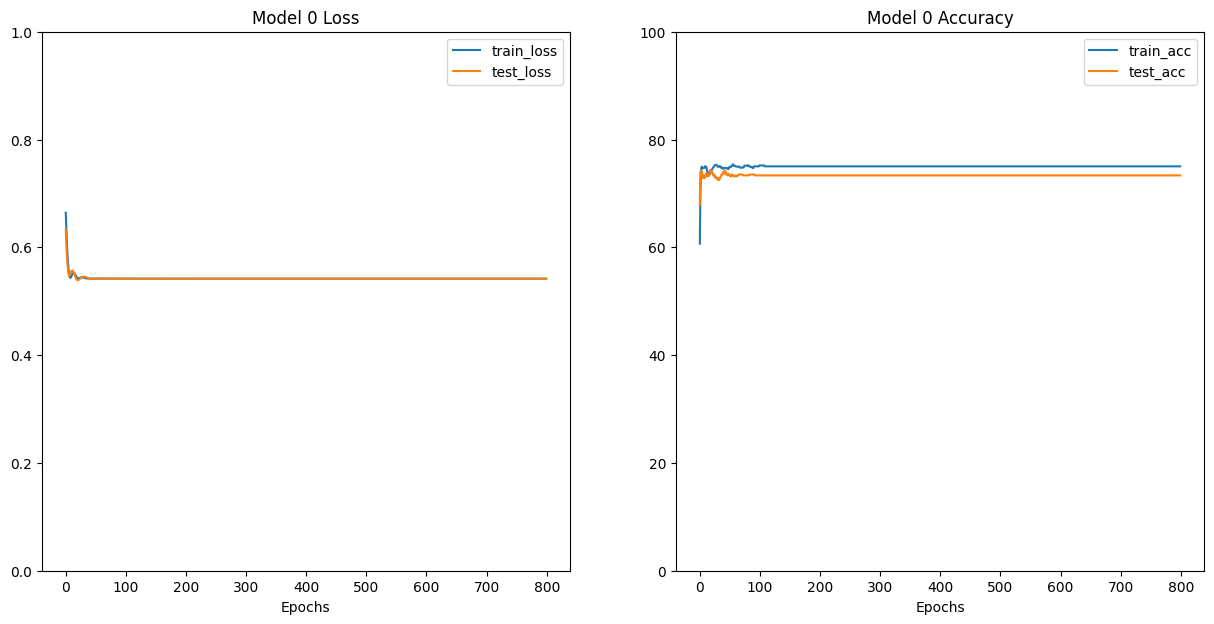

In [1749]:
plot_loss_curves(model_0_results, model_name="Model 0")

Building a better NN Model

In [1750]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V1(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_1 = Classification_V1(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_1

Classification_V1(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1751]:
optimizer, scheduler = get_optimizer_and_scheduler(model_1)

In [1752]:
model_1_results = train_model(model=model_1, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.70193 | Acc:  54.72% | Test Loss:  0.68627 | Test Acc:  56.71%
Epoch: 10 | Loss:  0.52638 | Acc:  74.98% | Test Loss:  0.52821 | Test Acc:  72.67%
Epoch: 20 | Loss:  0.48087 | Acc:  76.04% | Test Loss:  0.50981 | Test Acc:  76.74%
Epoch: 30 | Loss:  0.45315 | Acc:  77.06% | Test Loss:  0.50148 | Test Acc:  76.91%
Epoch: 40 | Loss:  0.43196 | Acc:  78.50% | Test Loss:  0.49484 | Test Acc:  77.42%
Epoch: 50 | Loss:  0.41316 | Acc:  79.35% | Test Loss:  0.48672 | Test Acc:  77.93%
Epoch: 60 | Loss:  0.39254 | Acc:  80.59% | Test Loss:  0.48478 | Test Acc:  78.44%
Epoch: 70 | Loss:  0.36905 | Acc:  81.82% | Test Loss:  0.48150 | Test Acc:  78.78%
Epoch: 80 | Loss:  0.34294 | Acc:  85.13% | Test Loss:  0.47361 | Test Acc:  78.95%
Epoch: 90 | Loss:  0.32023 | Acc:  86.58% | Test Loss:  0.48667 | Test Acc:  80.14%
Epoch: 100 | Loss:  0.30102 | Acc:  87.77% | Test Loss:  0.47520 | Test Acc:  82.51%
Epoch: 110 | Loss:  0.29840 | Acc:  87.94% | Test Loss:  0.47232 | Test Acc:

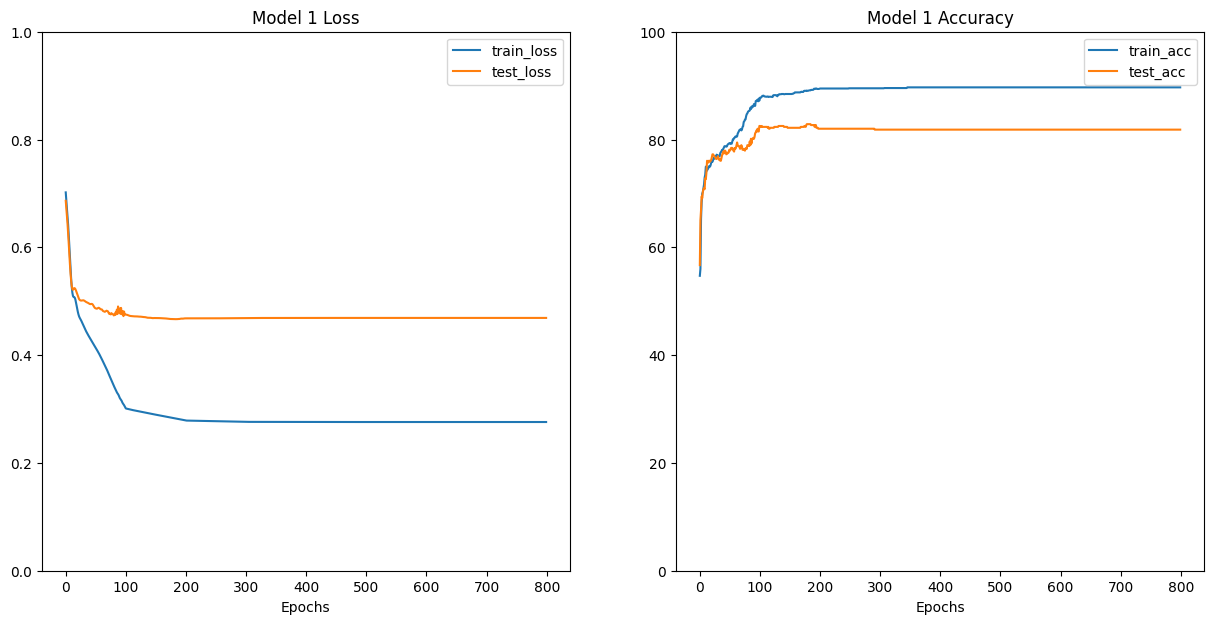

In [1753]:
plot_loss_curves(model_1_results, model_name="Model 1")

Try an even bigger model?

In [1754]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V2(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_2 = Classification_V2(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_2

Classification_V2(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1755]:
optimizer, scheduler = get_optimizer_and_scheduler(model_2)

In [1756]:
model_2_results = train_model(model=model_2, 
            optimizer=optimizer,
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.69042 | Acc:  54.72% | Test Loss:  0.68068 | Test Acc:  55.35%
Epoch: 10 | Loss:  0.52209 | Acc:  75.02% | Test Loss:  0.54238 | Test Acc:  74.53%
Epoch: 20 | Loss:  0.46679 | Acc:  77.57% | Test Loss:  0.50046 | Test Acc:  76.40%
Epoch: 30 | Loss:  0.43102 | Acc:  79.06% | Test Loss:  0.49817 | Test Acc:  76.23%
Epoch: 40 | Loss:  0.40418 | Acc:  80.76% | Test Loss:  0.47926 | Test Acc:  78.44%
Epoch: 50 | Loss:  0.36947 | Acc:  82.46% | Test Loss:  0.48094 | Test Acc:  77.59%
Epoch: 60 | Loss:  0.34189 | Acc:  85.13% | Test Loss:  0.46808 | Test Acc:  79.46%
Epoch: 70 | Loss:  0.30369 | Acc:  87.34% | Test Loss:  0.47497 | Test Acc:  80.31%
Epoch: 80 | Loss:  0.27456 | Acc:  88.83% | Test Loss:  0.49566 | Test Acc:  81.49%
Epoch: 90 | Loss:  0.25478 | Acc:  90.14% | Test Loss:  0.52107 | Test Acc:  81.15%
Epoch: 100 | Loss:  0.23990 | Acc:  90.53% | Test Loss:  0.57519 | Test Acc:  83.02%
Epoch: 110 | Loss:  0.23307 | Acc:  91.50% | Test Loss:  0.56423 | Test Acc:

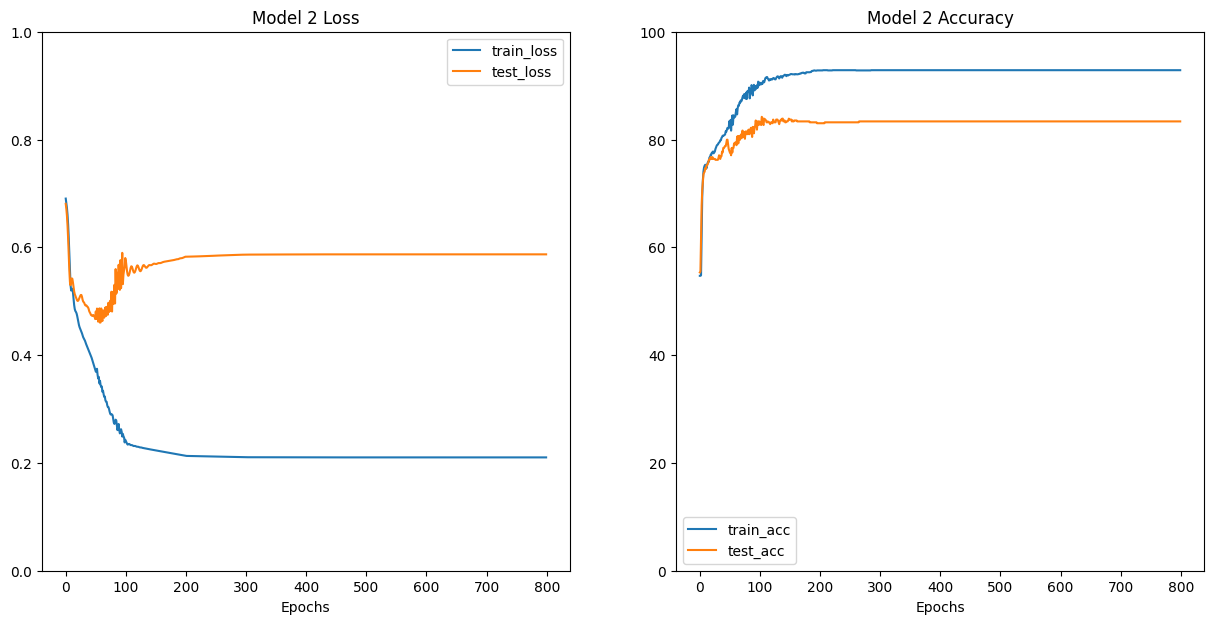

In [1757]:
plot_loss_curves(model_2_results, model_name="Model 2")

In [1758]:
class Classification_V3(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_3 = Classification_V3(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_3

Classification_V3(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1759]:
optimizer, scheduler = get_optimizer_and_scheduler(model_3)

In [1760]:
model_3_results = train_model(model=model_3, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.68836 | Acc:  54.72% | Test Loss:  0.67486 | Test Acc:  55.35%
Epoch: 10 | Loss:  0.50591 | Acc:  74.89% | Test Loss:  0.53109 | Test Acc:  75.72%
Epoch: 20 | Loss:  0.44779 | Acc:  78.46% | Test Loss:  0.50873 | Test Acc:  75.21%
Epoch: 30 | Loss:  0.41552 | Acc:  79.23% | Test Loss:  0.48935 | Test Acc:  76.40%
Epoch: 40 | Loss:  0.38341 | Acc:  82.29% | Test Loss:  0.49534 | Test Acc:  79.29%
Epoch: 50 | Loss:  0.34856 | Acc:  84.45% | Test Loss:  0.47638 | Test Acc:  80.65%
Epoch: 60 | Loss:  0.30796 | Acc:  87.26% | Test Loss:  0.50528 | Test Acc:  79.80%
Epoch: 70 | Loss:  0.27957 | Acc:  88.57% | Test Loss:  0.51926 | Test Acc:  80.14%
Epoch: 80 | Loss:  0.25097 | Acc:  90.40% | Test Loss:  0.53527 | Test Acc:  80.48%
Epoch: 90 | Loss:  0.22880 | Acc:  91.46% | Test Loss:  0.54177 | Test Acc:  82.68%
Epoch: 100 | Loss:  0.19333 | Acc:  93.12% | Test Loss:  0.50291 | Test Acc:  83.36%
Epoch: 110 | Loss:  0.18564 | Acc:  93.76% | Test Loss:  0.50787 | Test Acc:

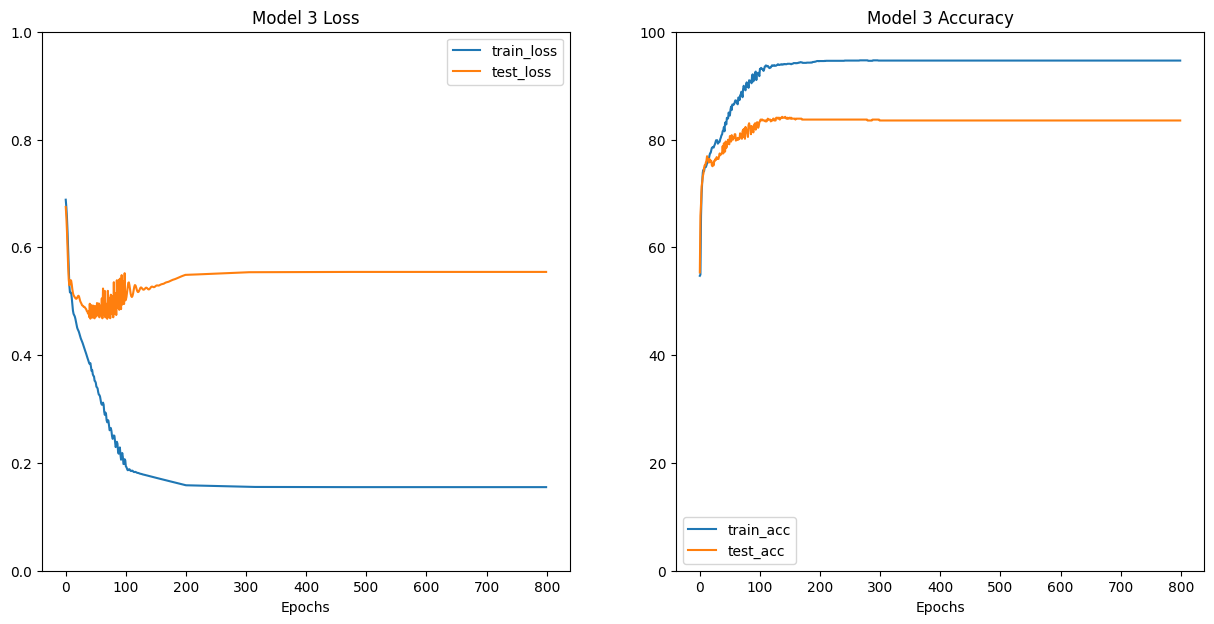

In [1761]:
plot_loss_curves(model_3_results, model_name="Model 3")

In [1762]:
# Slighly less complex model
class Classification_V4(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 2, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_4 = Classification_V4(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_4

Classification_V4(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [1763]:
optimizer, scheduler = get_optimizer_and_scheduler(model_4)

In [1764]:
model_4_results = train_model(model=model_4, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.70018 | Acc:  42.27% | Test Loss:  0.67728 | Test Acc:  67.74%
Epoch: 10 | Loss:  0.50758 | Acc:  74.17% | Test Loss:  0.52280 | Test Acc:  74.87%


Epoch: 20 | Loss:  0.46581 | Acc:  77.15% | Test Loss:  0.50516 | Test Acc:  74.87%
Epoch: 30 | Loss:  0.43928 | Acc:  78.25% | Test Loss:  0.49427 | Test Acc:  73.68%
Epoch: 40 | Loss:  0.41727 | Acc:  79.27% | Test Loss:  0.47873 | Test Acc:  76.57%
Epoch: 50 | Loss:  0.39457 | Acc:  81.05% | Test Loss:  0.46887 | Test Acc:  77.08%
Epoch: 60 | Loss:  0.36938 | Acc:  82.63% | Test Loss:  0.46018 | Test Acc:  77.59%
Epoch: 70 | Loss:  0.34369 | Acc:  84.20% | Test Loss:  0.45619 | Test Acc:  77.76%
Epoch: 80 | Loss:  0.32132 | Acc:  85.77% | Test Loss:  0.45327 | Test Acc:  79.12%
Epoch: 90 | Loss:  0.29745 | Acc:  87.38% | Test Loss:  0.45321 | Test Acc:  78.95%
Epoch: 100 | Loss:  0.27332 | Acc:  89.21% | Test Loss:  0.47683 | Test Acc:  79.46%
Epoch: 110 | Loss:  0.26927 | Acc:  89.21% | Test Loss:  0.47183 | Test Acc:  79.63%
Epoch: 120 | Loss:  0.26595 | Acc:  89.25% | Test Loss:  0.46897 | Test Acc:  79.63%
Epoch: 130 | Loss:  0.26300 | Acc:  89.34% | Test Loss:  0.46838 | Test A

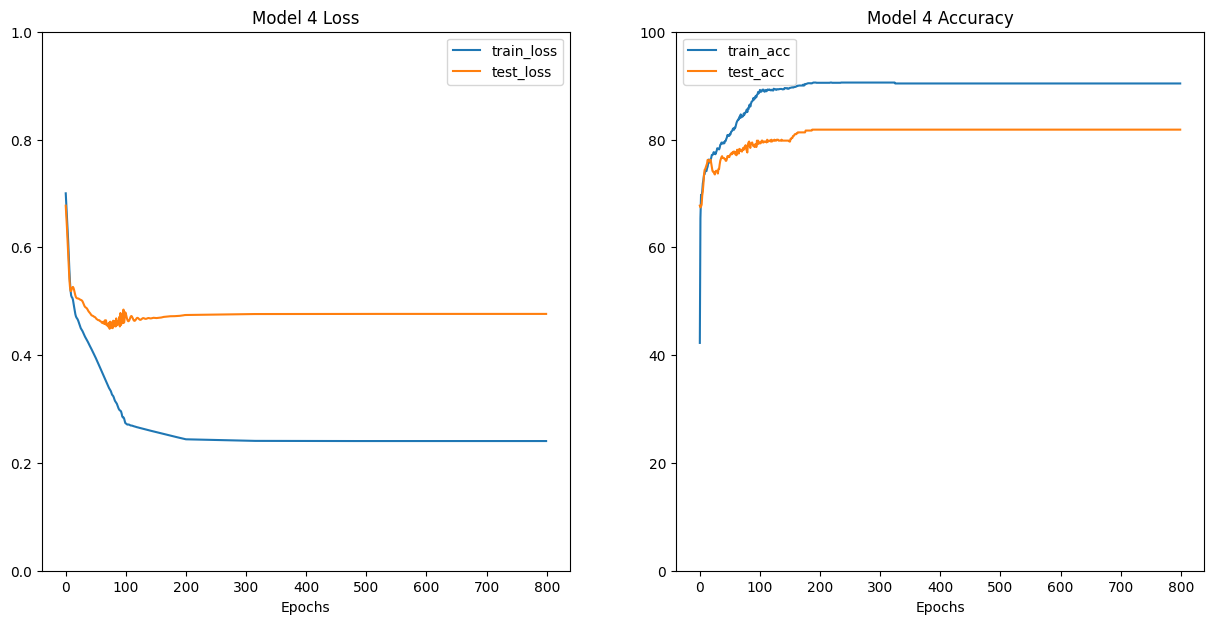

In [1765]:
plot_loss_curves(model_4_results, model_name="Model 4")

In [1766]:
# Slighly less complex model
class Classification_V5(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 2, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_5 = Classification_V5(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_5

Classification_V5(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [1767]:
optimizer, scheduler = get_optimizer_and_scheduler(model_5)

In [1768]:
model_5_results = train_model(model=model_5, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.74659 | Acc:  45.07% | Test Loss:  0.71463 | Test Acc:  47.20%
Epoch: 10 | Loss:  0.53312 | Acc:  73.96% | Test Loss:  0.53917 | Test Acc:  73.34%


Epoch: 20 | Loss:  0.48669 | Acc:  75.87% | Test Loss:  0.50817 | Test Acc:  75.21%
Epoch: 30 | Loss:  0.45911 | Acc:  77.10% | Test Loss:  0.49402 | Test Acc:  77.76%
Epoch: 40 | Loss:  0.44221 | Acc:  78.38% | Test Loss:  0.48969 | Test Acc:  77.59%
Epoch: 50 | Loss:  0.42923 | Acc:  79.52% | Test Loss:  0.48197 | Test Acc:  78.10%
Epoch: 60 | Loss:  0.41898 | Acc:  79.82% | Test Loss:  0.48275 | Test Acc:  77.59%
Epoch: 70 | Loss:  0.40892 | Acc:  80.63% | Test Loss:  0.47603 | Test Acc:  77.76%
Epoch: 80 | Loss:  0.39974 | Acc:  81.31% | Test Loss:  0.46892 | Test Acc:  77.93%
Epoch: 90 | Loss:  0.39159 | Acc:  81.31% | Test Loss:  0.46494 | Test Acc:  77.76%
Epoch: 100 | Loss:  0.38400 | Acc:  81.69% | Test Loss:  0.46132 | Test Acc:  77.93%
Epoch: 110 | Loss:  0.38306 | Acc:  81.90% | Test Loss:  0.46073 | Test Acc:  77.76%
Epoch: 120 | Loss:  0.38215 | Acc:  81.90% | Test Loss:  0.46010 | Test Acc:  78.27%
Epoch: 130 | Loss:  0.38125 | Acc:  82.07% | Test Loss:  0.45959 | Test A

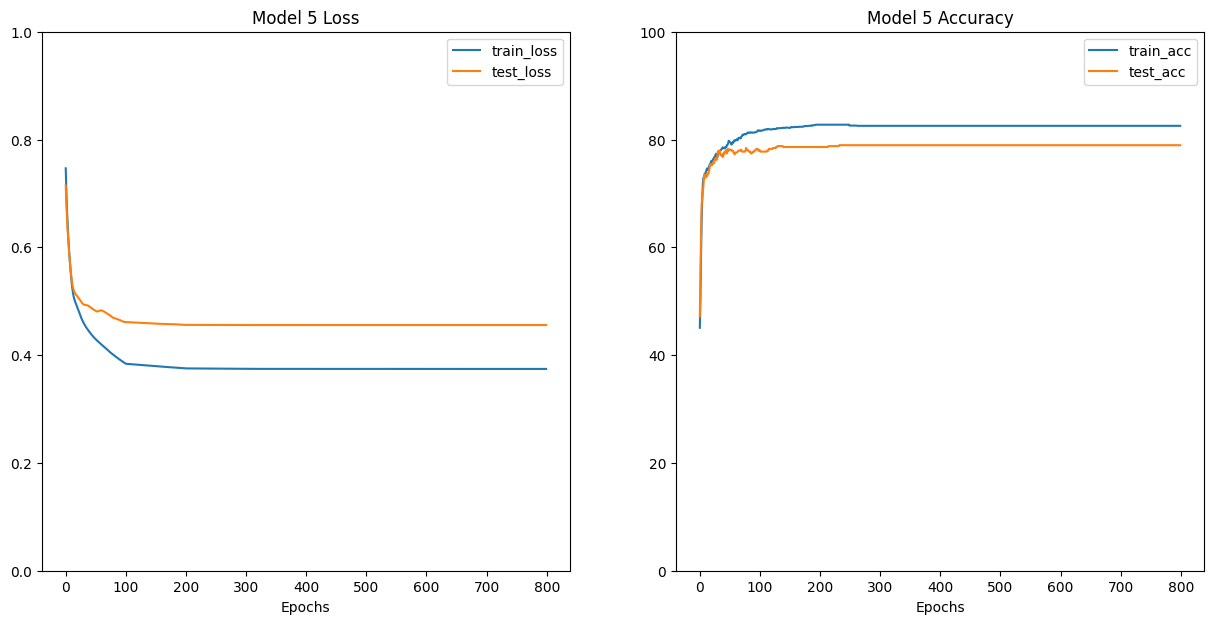

In [1769]:
plot_loss_curves(model_5_results, model_name="Model 5")

In [1770]:
# ascending hidden units this time
class Classification_V6(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 8),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 8, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_6 = Classification_V6(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_6

Classification_V6(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [1771]:
optimizer, scheduler = get_optimizer_and_scheduler(model_6)

In [1772]:
model_6_results = train_model(model=model_6, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.69474 | Acc:  45.28% | Test Loss:  0.66022 | Test Acc:  56.20%


Epoch: 10 | Loss:  0.46740 | Acc:  77.70% | Test Loss:  0.51666 | Test Acc:  75.72%
Epoch: 20 | Loss:  0.41536 | Acc:  79.91% | Test Loss:  0.48773 | Test Acc:  77.42%
Epoch: 30 | Loss:  0.36240 | Acc:  84.54% | Test Loss:  0.45156 | Test Acc:  79.97%
Epoch: 40 | Loss:  0.30943 | Acc:  86.66% | Test Loss:  0.42978 | Test Acc:  82.34%
Epoch: 50 | Loss:  0.25978 | Acc:  90.06% | Test Loss:  0.43572 | Test Acc:  80.98%
Epoch: 60 | Loss:  0.22445 | Acc:  91.59% | Test Loss:  0.43622 | Test Acc:  79.97%
Epoch: 70 | Loss:  0.20177 | Acc:  91.80% | Test Loss:  0.43216 | Test Acc:  81.66%
Epoch: 80 | Loss:  0.16659 | Acc:  93.76% | Test Loss:  0.44911 | Test Acc:  82.00%
Epoch: 90 | Loss:  0.16850 | Acc:  92.86% | Test Loss:  0.43961 | Test Acc:  86.25%
Epoch: 100 | Loss:  0.12156 | Acc:  95.79% | Test Loss:  0.47208 | Test Acc:  86.25%
Epoch: 110 | Loss:  0.10735 | Acc:  96.43% | Test Loss:  0.45522 | Test Acc:  85.91%
Epoch: 120 | Loss:  0.09983 | Acc:  97.11% | Test Loss:  0.47147 | Test Ac

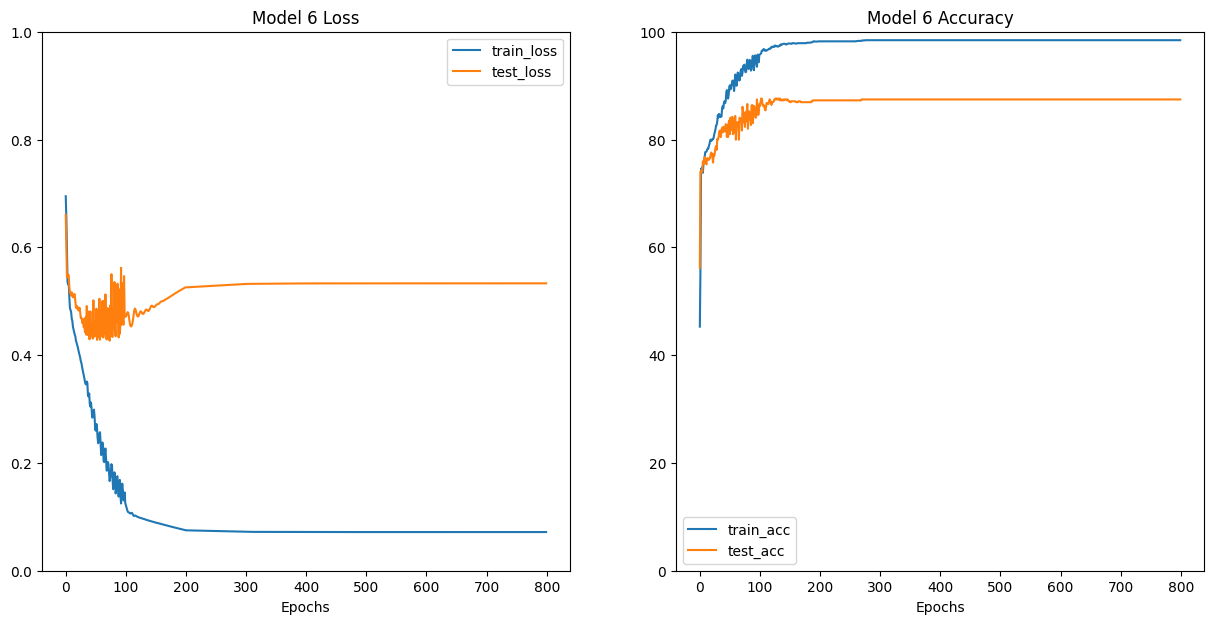

In [1773]:
plot_loss_curves(model_6_results, model_name="Model 6")

In [1774]:
# less complication version of v6
class Classification_V7(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 4, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_7 = Classification_V7(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_7

Classification_V7(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [1775]:
optimizer, scheduler = get_optimizer_and_scheduler(model_7)

In [1776]:
model_7_results = train_model(model=model_7, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.68839 | Acc:  54.46% | Test Loss:  0.63699 | Test Acc:  65.20%


Epoch: 10 | Loss:  0.46617 | Acc:  77.02% | Test Loss:  0.50570 | Test Acc:  76.23%
Epoch: 20 | Loss:  0.42330 | Acc:  79.61% | Test Loss:  0.49237 | Test Acc:  77.25%
Epoch: 30 | Loss:  0.38996 | Acc:  81.35% | Test Loss:  0.46417 | Test Acc:  78.61%
Epoch: 40 | Loss:  0.35477 | Acc:  83.94% | Test Loss:  0.45269 | Test Acc:  78.27%
Epoch: 50 | Loss:  0.31433 | Acc:  85.81% | Test Loss:  0.44876 | Test Acc:  79.46%
Epoch: 60 | Loss:  0.27874 | Acc:  88.74% | Test Loss:  0.44084 | Test Acc:  79.97%
Epoch: 70 | Loss:  0.24659 | Acc:  90.70% | Test Loss:  0.44708 | Test Acc:  81.49%
Epoch: 80 | Loss:  0.23288 | Acc:  91.76% | Test Loss:  0.48452 | Test Acc:  82.00%
Epoch: 90 | Loss:  0.20226 | Acc:  92.69% | Test Loss:  0.46473 | Test Acc:  82.68%
Epoch: 100 | Loss:  0.19585 | Acc:  92.35% | Test Loss:  0.49519 | Test Acc:  83.02%
Epoch: 110 | Loss:  0.18648 | Acc:  93.12% | Test Loss:  0.48293 | Test Acc:  82.85%
Epoch: 120 | Loss:  0.18265 | Acc:  93.59% | Test Loss:  0.47879 | Test Ac

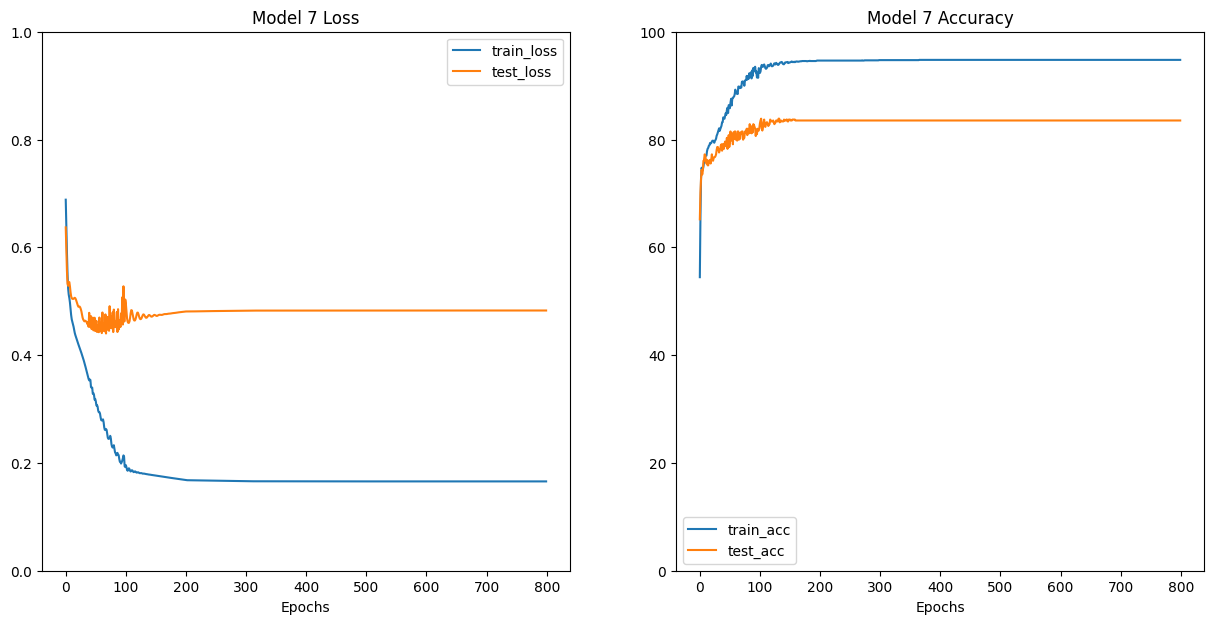

In [1777]:
plot_loss_curves(model_7_results, model_name="Model 7")

Adding dropout layers to further fight overfitting

In [1778]:
DROPOUT_RATE=0.6

In [1779]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V1_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_1_dropout = Classification_V1_Dropout(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1, 
                            dropout_rate=DROPOUT_RATE).to(device)
model_1_dropout

Classification_V1_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1780]:
optimizer, scheduler = get_optimizer_and_scheduler(model_1_dropout)

In [1781]:
model_1_dropout_results = train_model(model=model_1_dropout, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.70964 | Acc:  51.66% | Test Loss:  0.69021 | Test Acc:  57.39%
Epoch: 10 | Loss:  0.59349 | Acc:  69.07% | Test Loss:  0.55073 | Test Acc:  73.51%
Epoch: 20 | Loss:  0.54881 | Acc:  72.73% | Test Loss:  0.50850 | Test Acc:  75.55%
Epoch: 30 | Loss:  0.53218 | Acc:  74.38% | Test Loss:  0.50491 | Test Acc:  75.04%
Epoch: 40 | Loss:  0.50404 | Acc:  75.28% | Test Loss:  0.50177 | Test Acc:  75.04%
Epoch: 50 | Loss:  0.50510 | Acc:  75.15% | Test Loss:  0.49671 | Test Acc:  75.72%
Epoch: 60 | Loss:  0.49780 | Acc:  75.57% | Test Loss:  0.49477 | Test Acc:  75.55%
Epoch: 70 | Loss:  0.49982 | Acc:  76.04% | Test Loss:  0.48624 | Test Acc:  76.06%
Epoch: 80 | Loss:  0.48803 | Acc:  76.89% | Test Loss:  0.48038 | Test Acc:  77.08%
Epoch: 90 | Loss:  0.48243 | Acc:  77.27% | Test Loss:  0.47746 | Test Acc:  78.10%
Epoch: 100 | Loss:  0.48280 | Acc:  76.04% | Test Loss:  0.47909 | Test Acc:  77.08%
Epoch: 110 | Loss:  0.48520 | Acc:  76.13% | Test Loss:  0.47797 | Test Acc:

Epoch: 150 | Loss:  0.48162 | Acc:  77.36% | Test Loss:  0.47692 | Test Acc:  77.59%
Epoch: 160 | Loss:  0.48075 | Acc:  76.81% | Test Loss:  0.47628 | Test Acc:  77.42%
Epoch: 170 | Loss:  0.48172 | Acc:  76.81% | Test Loss:  0.47582 | Test Acc:  77.59%
Epoch: 180 | Loss:  0.46908 | Acc:  77.74% | Test Loss:  0.47549 | Test Acc:  77.93%
Epoch: 190 | Loss:  0.48122 | Acc:  77.70% | Test Loss:  0.47497 | Test Acc:  77.93%
Epoch: 200 | Loss:  0.46553 | Acc:  78.42% | Test Loss:  0.47465 | Test Acc:  78.10%
Epoch: 210 | Loss:  0.47699 | Acc:  76.59% | Test Loss:  0.47460 | Test Acc:  78.10%
Epoch: 220 | Loss:  0.46454 | Acc:  79.06% | Test Loss:  0.47461 | Test Acc:  78.10%
Epoch: 230 | Loss:  0.47815 | Acc:  76.42% | Test Loss:  0.47465 | Test Acc:  78.10%
Epoch: 240 | Loss:  0.46987 | Acc:  77.02% | Test Loss:  0.47461 | Test Acc:  78.10%
Epoch: 250 | Loss:  0.48219 | Acc:  77.61% | Test Loss:  0.47466 | Test Acc:  77.93%
Epoch: 260 | Loss:  0.47445 | Acc:  77.44% | Test Loss:  0.47470 

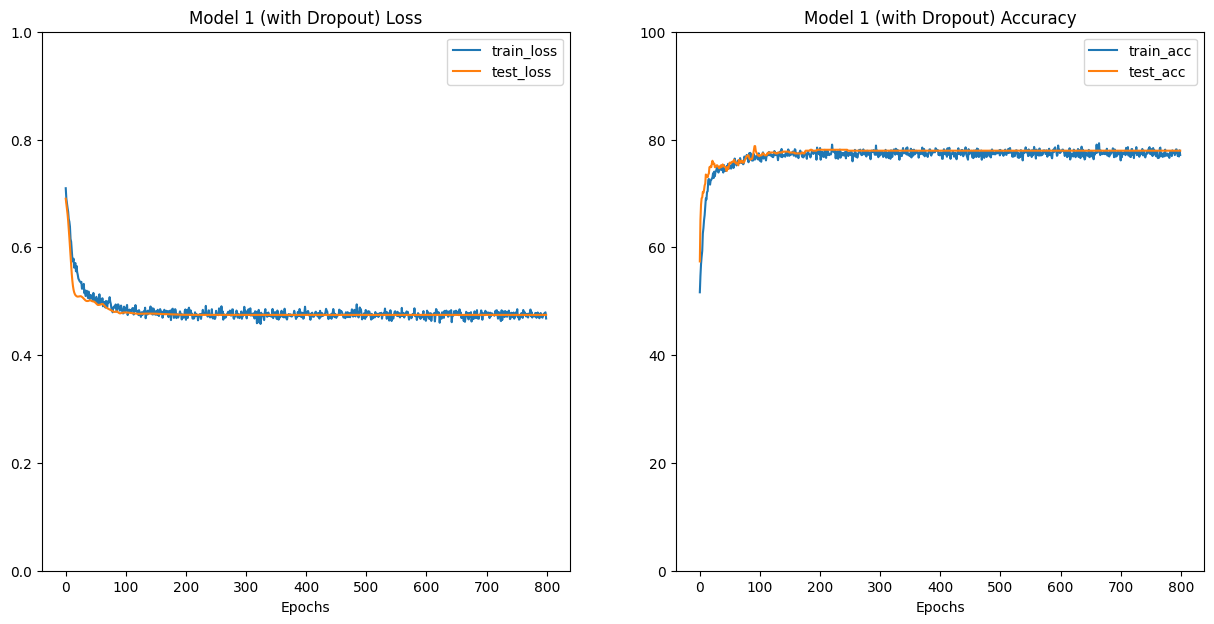

In [1782]:
plot_loss_curves(model_1_dropout_results, model_name="Model 1 (with Dropout)")

In [1783]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V2_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_2_dropout = Classification_V2_Dropout(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1, 
                            dropout_rate=DROPOUT_RATE).to(device)
model_2_dropout

Classification_V2_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1784]:
optimizer, scheduler = get_optimizer_and_scheduler(model_2_dropout)

In [1785]:
model_2_dropout_results = train_model(model=model_2_dropout, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.69302 | Acc:  54.25% | Test Loss:  0.68475 | Test Acc:  55.35%
Epoch: 10 | Loss:  0.59982 | Acc:  67.71% | Test Loss:  0.54292 | Test Acc:  73.01%
Epoch: 20 | Loss:  0.56489 | Acc:  72.18% | Test Loss:  0.52323 | Test Acc:  73.51%
Epoch: 30 | Loss:  0.52485 | Acc:  74.89% | Test Loss:  0.50307 | Test Acc:  74.70%
Epoch: 40 | Loss:  0.51323 | Acc:  74.81% | Test Loss:  0.49572 | Test Acc:  74.70%
Epoch: 50 | Loss:  0.51224 | Acc:  75.45% | Test Loss:  0.48889 | Test Acc:  74.36%
Epoch: 60 | Loss:  0.50341 | Acc:  76.34% | Test Loss:  0.48598 | Test Acc:  76.57%
Epoch: 70 | Loss:  0.48666 | Acc:  76.64% | Test Loss:  0.48348 | Test Acc:  76.91%
Epoch: 80 | Loss:  0.49554 | Acc:  77.32% | Test Loss:  0.47736 | Test Acc:  77.42%
Epoch: 90 | Loss:  0.48531 | Acc:  77.15% | Test Loss:  0.47685 | Test Acc:  76.74%
Epoch: 100 | Loss:  0.48577 | Acc:  77.32% | Test Loss:  0.47414 | Test Acc:  78.10%
Epoch: 110 | Loss:  0.48833 | Acc:  76.55% | Test Loss:  0.47280 | Test Acc:

Epoch: 130 | Loss:  0.47214 | Acc:  77.74% | Test Loss:  0.47143 | Test Acc:  78.27%
Epoch: 140 | Loss:  0.47974 | Acc:  78.04% | Test Loss:  0.47112 | Test Acc:  78.10%
Epoch: 150 | Loss:  0.47580 | Acc:  77.36% | Test Loss:  0.47043 | Test Acc:  78.27%
Epoch: 160 | Loss:  0.46710 | Acc:  77.91% | Test Loss:  0.46983 | Test Acc:  78.78%
Epoch: 170 | Loss:  0.47627 | Acc:  78.38% | Test Loss:  0.46921 | Test Acc:  78.44%
Epoch: 180 | Loss:  0.48338 | Acc:  77.66% | Test Loss:  0.46862 | Test Acc:  78.27%
Epoch: 190 | Loss:  0.47473 | Acc:  78.21% | Test Loss:  0.46857 | Test Acc:  77.76%
Epoch: 200 | Loss:  0.47505 | Acc:  77.95% | Test Loss:  0.46760 | Test Acc:  78.10%
Epoch: 210 | Loss:  0.47034 | Acc:  77.99% | Test Loss:  0.46759 | Test Acc:  78.10%
Epoch: 220 | Loss:  0.47014 | Acc:  77.78% | Test Loss:  0.46771 | Test Acc:  78.27%
Epoch: 230 | Loss:  0.46846 | Acc:  77.87% | Test Loss:  0.46788 | Test Acc:  78.10%
Epoch: 240 | Loss:  0.46849 | Acc:  78.08% | Test Loss:  0.46801 

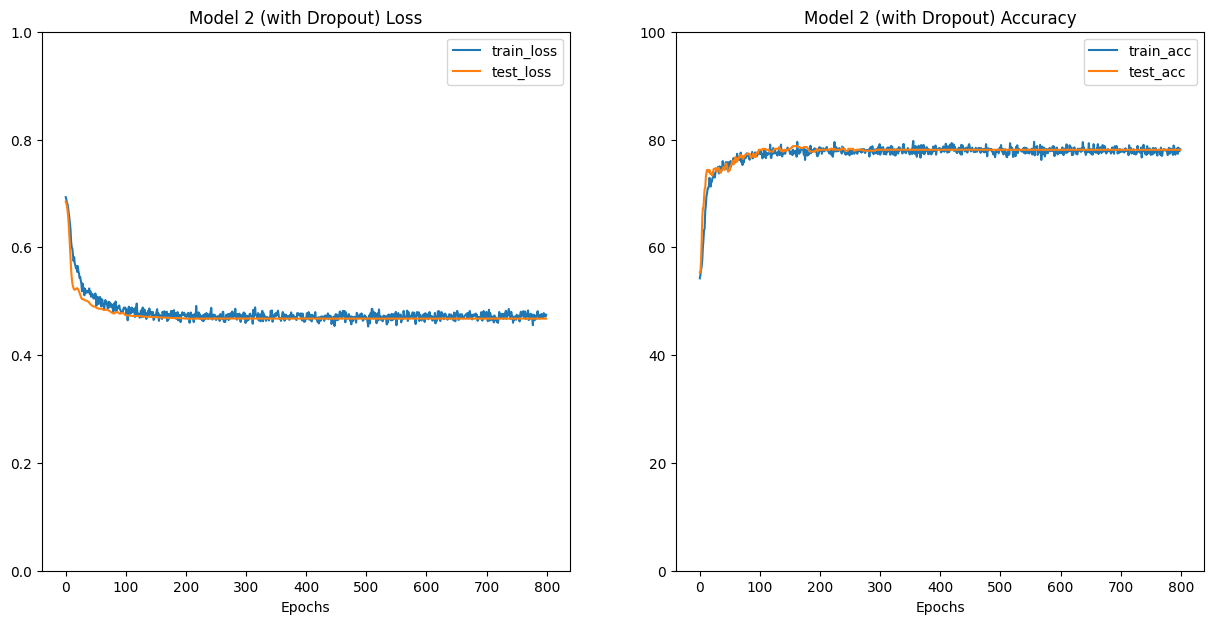

In [1786]:
plot_loss_curves(model_2_dropout_results, model_name="Model 2 (with Dropout)")

In [1787]:
class Classification_V3_Dropout(nn.Module):
  def __init__(self, input_shape: int,
              hidden_units: int,
              output_shape: int, 
              dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_3_dropout = Classification_V3_Dropout(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1, 
                            dropout_rate=DROPOUT_RATE).to(device)
model_3_dropout 

Classification_V3_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1788]:
optimizer, scheduler = get_optimizer_and_scheduler(model_3_dropout)

In [1789]:
model_3_dropout_results = train_model(model=model_3_dropout, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.70001 | Acc:  49.07% | Test Loss:  0.68225 | Test Acc:  55.35%
Epoch: 10 | Loss:  0.60111 | Acc:  70.56% | Test Loss:  0.54715 | Test Acc:  73.17%


Epoch: 20 | Loss:  0.55007 | Acc:  73.19% | Test Loss:  0.51905 | Test Acc:  75.21%
Epoch: 30 | Loss:  0.50688 | Acc:  75.45% | Test Loss:  0.50460 | Test Acc:  73.51%
Epoch: 40 | Loss:  0.49420 | Acc:  75.66% | Test Loss:  0.49386 | Test Acc:  76.23%
Epoch: 50 | Loss:  0.49985 | Acc:  76.30% | Test Loss:  0.49080 | Test Acc:  76.57%
Epoch: 60 | Loss:  0.49787 | Acc:  76.55% | Test Loss:  0.48472 | Test Acc:  77.76%
Epoch: 70 | Loss:  0.48103 | Acc:  77.32% | Test Loss:  0.48226 | Test Acc:  78.95%
Epoch: 80 | Loss:  0.48601 | Acc:  77.61% | Test Loss:  0.47919 | Test Acc:  77.93%
Epoch: 90 | Loss:  0.48038 | Acc:  77.53% | Test Loss:  0.47788 | Test Acc:  77.93%
Epoch: 100 | Loss:  0.47880 | Acc:  76.55% | Test Loss:  0.47241 | Test Acc:  78.95%
Epoch: 110 | Loss:  0.48634 | Acc:  77.19% | Test Loss:  0.47293 | Test Acc:  78.44%
Epoch: 120 | Loss:  0.47244 | Acc:  77.82% | Test Loss:  0.47140 | Test Acc:  78.78%
Epoch: 130 | Loss:  0.46769 | Acc:  78.89% | Test Loss:  0.47077 | Test A

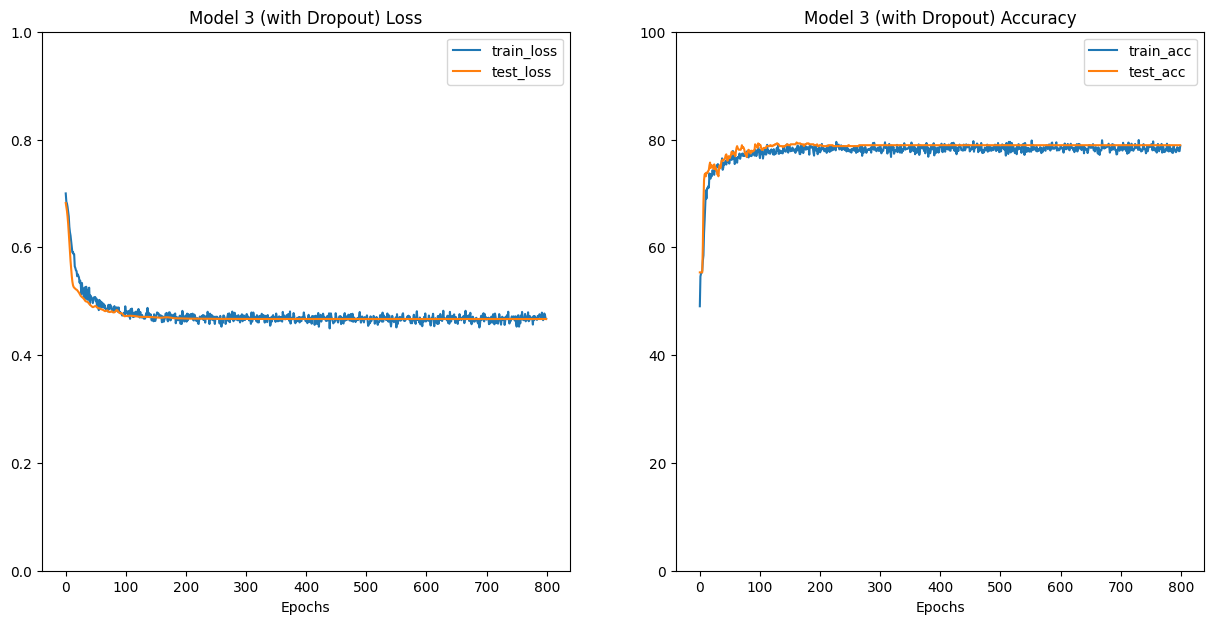

In [1790]:
plot_loss_curves(model_3_dropout_results, model_name="Model 3 (with Dropout)")

In [1791]:
# Slighly less complex model
class Classification_V5_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    # modified to add more dropout
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 2, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_5_dropout = Classification_V5_Dropout(input_shape=INPUT_SHAPE, 
                                            hidden_units=HIDDEN_UNITS, 
                                            output_shape=1, 
                                            dropout_rate=DROPOUT_RATE).to(device)
model_5_dropout

Classification_V5_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [1792]:
optimizer, scheduler = get_optimizer_and_scheduler(model_5_dropout)

In [1793]:
model_5_dropout_results = train_model(model=model_5_dropout, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.68658 | Acc:  52.85% | Test Loss:  0.65695 | Test Acc:  55.35%
Epoch: 10 | Loss:  0.54930 | Acc:  72.64% | Test Loss:  0.51469 | Test Acc:  74.19%


Epoch: 20 | Loss:  0.49998 | Acc:  75.15% | Test Loss:  0.50804 | Test Acc:  73.34%
Epoch: 30 | Loss:  0.48835 | Acc:  75.36% | Test Loss:  0.49769 | Test Acc:  74.87%
Epoch: 40 | Loss:  0.48482 | Acc:  77.44% | Test Loss:  0.49184 | Test Acc:  75.55%
Epoch: 50 | Loss:  0.46444 | Acc:  76.55% | Test Loss:  0.49015 | Test Acc:  77.08%
Epoch: 60 | Loss:  0.45525 | Acc:  77.82% | Test Loss:  0.48158 | Test Acc:  77.42%
Epoch: 70 | Loss:  0.46317 | Acc:  77.19% | Test Loss:  0.48159 | Test Acc:  76.74%
Epoch: 80 | Loss:  0.45459 | Acc:  77.06% | Test Loss:  0.47787 | Test Acc:  76.91%
Epoch: 90 | Loss:  0.44610 | Acc:  78.89% | Test Loss:  0.47152 | Test Acc:  77.93%
Epoch: 100 | Loss:  0.43899 | Acc:  79.01% | Test Loss:  0.47435 | Test Acc:  77.76%
Epoch: 110 | Loss:  0.43545 | Acc:  79.48% | Test Loss:  0.47141 | Test Acc:  77.76%
Epoch: 120 | Loss:  0.43634 | Acc:  79.10% | Test Loss:  0.46834 | Test Acc:  77.76%
Epoch: 130 | Loss:  0.43605 | Acc:  79.48% | Test Loss:  0.46767 | Test A

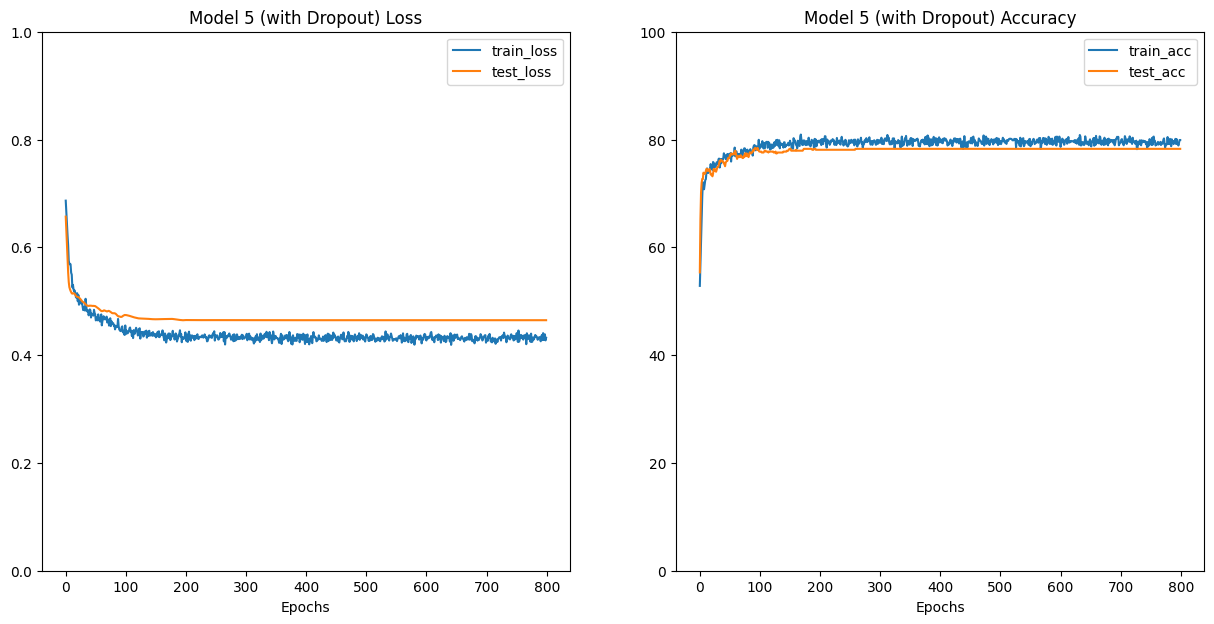

In [1794]:
plot_loss_curves(model_5_dropout_results, model_name="Model 5 (with Dropout)")

In [1795]:
# ascending hidden units this time
class Classification_V6_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 8),
        nn.ReLU(),
        nn.Dropout(dropout_rate), 
        nn.Linear(in_features=hidden_units * 8, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_6_dropout = Classification_V6_Dropout(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1, 
                            dropout_rate=DROPOUT_RATE).to(device)
model_6_dropout

Classification_V6_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [1796]:
optimizer, scheduler = get_optimizer_and_scheduler(model_6_dropout)

In [1797]:
model_6_dropout_results = train_model(model=model_6_dropout, 
            optimizer=optimizer, 
            scheduler=scheduler,
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.69771 | Acc:  49.11% | Test Loss:  0.67022 | Test Acc:  55.35%


Epoch: 10 | Loss:  0.54094 | Acc:  73.19% | Test Loss:  0.52387 | Test Acc:  74.70%
Epoch: 20 | Loss:  0.50266 | Acc:  75.70% | Test Loss:  0.50485 | Test Acc:  75.55%
Epoch: 30 | Loss:  0.49109 | Acc:  75.87% | Test Loss:  0.48982 | Test Acc:  77.08%
Epoch: 40 | Loss:  0.47392 | Acc:  76.68% | Test Loss:  0.48412 | Test Acc:  76.23%
Epoch: 50 | Loss:  0.46814 | Acc:  77.32% | Test Loss:  0.47720 | Test Acc:  76.57%
Epoch: 60 | Loss:  0.46426 | Acc:  77.32% | Test Loss:  0.47086 | Test Acc:  77.25%
Epoch: 70 | Loss:  0.44471 | Acc:  78.84% | Test Loss:  0.46895 | Test Acc:  77.59%
Epoch: 80 | Loss:  0.45670 | Acc:  78.46% | Test Loss:  0.46588 | Test Acc:  77.08%
Epoch: 90 | Loss:  0.45088 | Acc:  78.84% | Test Loss:  0.45898 | Test Acc:  78.10%
Epoch: 100 | Loss:  0.44717 | Acc:  78.12% | Test Loss:  0.45485 | Test Acc:  78.78%
Epoch: 110 | Loss:  0.44200 | Acc:  79.10% | Test Loss:  0.45488 | Test Acc:  78.95%
Epoch: 120 | Loss:  0.44874 | Acc:  78.80% | Test Loss:  0.45365 | Test Ac

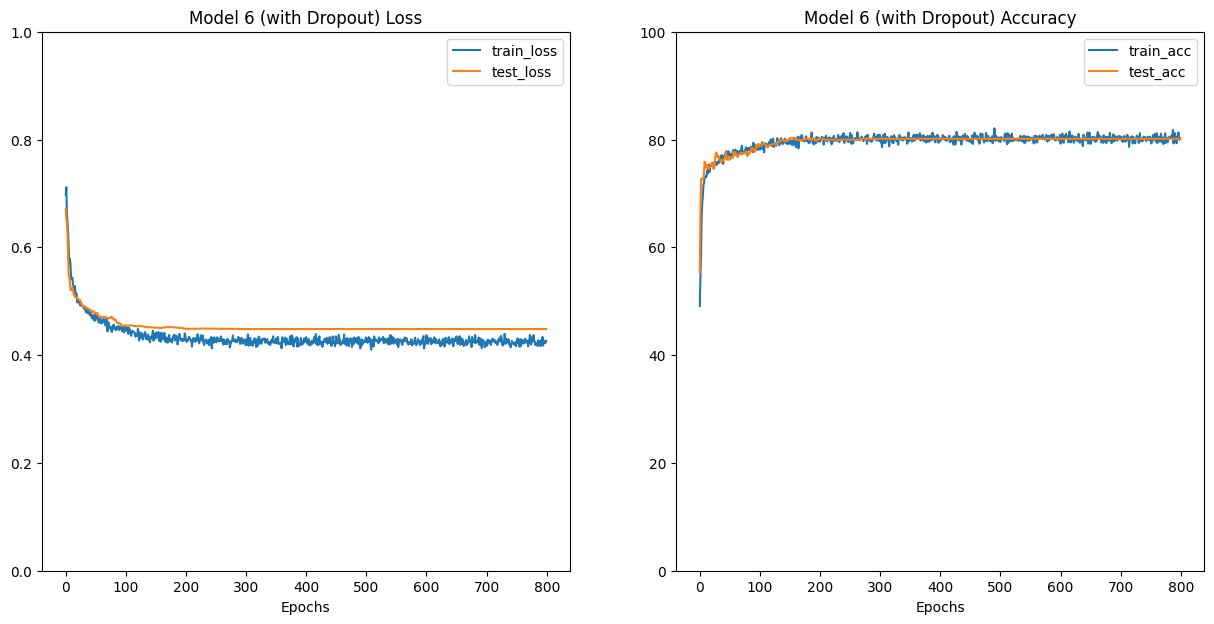

In [1798]:
plot_loss_curves(model_6_dropout_results, model_name="Model 6 (with Dropout)")